# [E-09] 영화리뷰 텍스트 감성분석하기


### 목표 : 영화 리뷰 평점 데이터를 사용하여 리뷰 감성을 분류하는 text 분류모델을 구현하기
<br>

|평가문항|상세기준|
|:---|:---|
|1.다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. |3가지 이상의 모델이 성공적으로 시도됨 |
|2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.|gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함|
|3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.|네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함|

<br>

### (1) 라이브러리 import 


In [1]:
import os
import pandas as pd
import numpy as np
import urllib.request
%matplotlib inline

import re
import matplotlib.pyplot as plt
import tensorflow as tf
from konlpy.tag import Okt

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter


In [2]:
# 데이터 불러오기
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.shape

(150000, 3)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


### (2) 데이터 준비
- tokenizer는 ```Mecab```을 사용
- 불용어도 간단하게 정의 후 전처리에 사용

In [5]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

### (3) index_to_word생성
- ```word_to_index```를 활용해서 새로운 ```index_to_word```생성
- 그 외에 인덱스를 입력하면 단어로 리턴해주는 함수, 단어를 입력하면 인덱스로 리턴해주는 함수를 정의

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

### (4) 모델구성을 위한 데이터 분석 및 가공


In [8]:
# 데이터셋 내 문장 길이 분포

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함 '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함 


In [9]:
# 적절한 최대 문장 길이 지정
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


In [10]:
print(X_test.shape)

(49157, 41)


### (5) validation set 구성 및 모델선정

####  a. validation set 구성

In [11]:
len(X_train)

146182

In [12]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지는 train set
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)
print(x_val.shape)
print(y_val.shape)

(126182, 41)
(126182,)
(20000, 41)
(20000,)


#### b. model 선정
- 같은 파라미터로 3가지 모델을 학습하기로 함
    1. 1-D CNN
    2. LSTM
    3. GlobalMaxPooling1D

In [13]:
# 세가지 모델을 평가할 때, 파라미터는 고정으로 사용
vocab_size = len(index_to_word)
word_vector_dim = 300

#### 1-D CNN

In [14]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()


In [15]:
# CNN

CNN_model = keras.Sequential(name="CNN")
CNN_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN_model.add(keras.layers.Conv1D(256, 7, activation='relu'))
CNN_model.add(keras.layers.MaxPooling1D(5))
CNN_model.add(keras.layers.Conv1D(64, 7, activation='relu'))
CNN_model.add(keras.layers.GlobalMaxPooling1D())
CNN_model.add(keras.layers.Dense(8, activation='relu'))
CNN_model.add(keras.layers.Dense(1, activation='sigmoid'))
CNN_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         28928     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 256)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          114752    
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 520       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9       

#### LSTM

In [16]:
# LSTM

LSTM_model = keras.Sequential(name="LSTM")
LSTM_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(keras.layers.LSTM(8, dropout=0.7))
LSTM_model.add(keras.layers.Dense(8, activation='relu'))
LSTM_model.add(keras.layers.Dense(1, activation='sigmoid'))

LSTM_model.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


#### GlobalMaxPooling1D

In [17]:
# GlobalMaxPooling1D

GMP_model = keras.Sequential(name="GMP")
GMP_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
GMP_model.add(keras.layers.GlobalMaxPooling1D())
GMP_model.add(keras.layers.Dense(8, activation='relu'))
GMP_model.add(keras.layers.Dense(1, activation='sigmoid'))

GMP_model.summary()

Model: "GMP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


#### 3가지 모델을 같은 조건에서 학습 후 결과 확인

In [18]:
model_lst = [CNN_model.name, LSTM_model.name, GMP_model.name]
model_lst

['CNN', 'LSTM', 'GMP']

In [19]:
model_result = {}

for model_name in model_lst:
    
    if model_name == "CNN":
        model = CNN_model
    elif model_name == "LSTM":
        model = LSTM_model
    else :
        model = GMP_model
    
    print('-'*40)
    print("Start fitting {} ...".format(model_name))
    model.compile(optimizer='Adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    epochs=20

    history = model.fit(partial_X_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=1)
    
    
    print("Start evaluating {} ...".format(model_name))
    results = model.evaluate(X_test,  y_test, verbose=2)
    model_result[model_name] = results

----------------------------------------
Start fitting CNN ...
Epoch 1/20
247/247 [==============================] - 6s 10ms/step - loss: 0.4595 - accuracy: 0.7628 - val_loss: 0.3516 - val_accuracy: 0.8463
Epoch 2/20
247/247 [==============================] - 2s 8ms/step - loss: 0.3223 - accuracy: 0.8624 - val_loss: 0.3340 - val_accuracy: 0.8544
Epoch 3/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2897 - accuracy: 0.8795 - val_loss: 0.3349 - val_accuracy: 0.8554
Epoch 4/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2599 - accuracy: 0.8944 - val_loss: 0.3384 - val_accuracy: 0.8569
Epoch 5/20
247/247 [==============================] - 2s 8ms/step - loss: 0.2249 - accuracy: 0.9116 - val_loss: 0.3646 - val_accuracy: 0.8537
Epoch 6/20
247/247 [==============================] - 2s 8ms/step - loss: 0.1898 - accuracy: 0.9280 - val_loss: 0.3974 - val_accuracy: 0.8501
Epoch 7/20
247/247 [==============================] - 2s 8ms/step - loss: 0.1554 - a

In [20]:
for name, [_, acc] in sorted(model_result.items(), key=lambda x : x[1][1], reverse=True) :
    print(name,'\t',acc)

LSTM 	 0.8518420457839966
GMP 	 0.8244807720184326
CNN 	 0.8236263394355774


- 이후에 가장 성능이 좋은 모델 선택 후 파라미터 튜닝을 수행

### (6) 모델 훈련

- 위의 모델 중에서 LSTM의 성능이 가장 좋은것을 확인
- 모델을 훈련하기 전에 먼저 성능을 올릴 수 있는 최적의 하이퍼파라미터를 찾아보기

In [21]:
word_vector_dim = 1000  # 워드 벡터의 차원수

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# CNN을 추가했을 때
# model.add(keras.layers.Conv1D(8, 7, activation='relu'))
# model.add(keras.layers.MaxPooling1D())
# LSTM 레이어를 두개로 학습했을 때
# model.add(keras.layers.LSTM(256, dropout=0.7, return_sequences=True))
model.add(keras.layers.LSTM(128, dropout=0.7))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 이진분류

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 1000)        10000000  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               578048    
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 10,579,089
Trainable params: 10,579,089
Non-trainable params: 0
_________________________________________________________________


In [22]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
model_check = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

```optimizer```에서 사용하는 ```Adam```에도 ```learning rate```를 조절해주었다.  

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
986/986 [==============================] - 17s 16ms/step - loss: 0.5659 - accuracy: 0.6821 - val_loss: 0.4923 - val_accuracy: 0.7827

Epoch 00001: val_accuracy improved from -inf to 0.78270, saving model to model.h5
Epoch 2/20
986/986 [==============================] - 15s 15ms/step - loss: 0.3827 - accuracy: 0.8313 - val_loss: 0.3480 - val_accuracy: 0.8467

Epoch 00002: val_accuracy improved from 0.78270 to 0.84665, saving model to model.h5
Epoch 3/20
986/986 [==============================] - 15s 15ms/step - loss: 0.3279 - accuracy: 0.8593 - val_loss: 0.3351 - val_accuracy: 0.8564

Epoch 00003: val_accuracy improved from 0.84665 to 0.85635, saving model to model.h5
Epoch 4/20
986/986 [==============================] - 15s 15ms/step - loss: 0.2995 - accuracy: 0.8720 - val_loss: 0.3292 - val_accuracy: 0.8618

Epoch 00004: val_accuracy improved from 0.85635 to 0.86175, saving model to model.h5
Epoch 5/20
986/986 [==============================] - 15s 15ms/step - loss: 0.2740 

In [24]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3578 - accuracy: 0.8566
[0.3577619194984436, 0.85664302110672]


이렇게 학습시킨 결과 ```0.852```에서 ```0.857```로 정확도가 상승하였다.

### (7) Loss, Accuracy 그래프 시각화


In [25]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


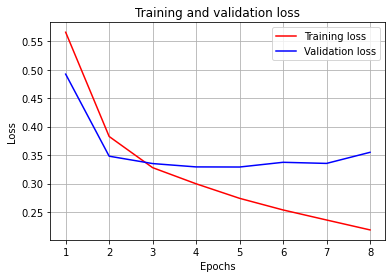

In [26]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

### (8) 학습된 Embedding 레이어 분석

In [27]:
import os
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors
from tensorflow.keras.initializers import Constant

In [28]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 1000)


위에서 학습시킨 ```word2vector```를 저장시킨다.

In [29]:
# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀작성


# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

```gensim```을 사용해서 학습시킨 ```word2vector```를 사용해서 ```대박```이라는 단어와 연관성이 있는 단어들을 뽑아보았다. 데이터를 엄청난 숫자로 넣은것은 아니라 한계가 있지 않을까 했지만 그래도 긍정적인 평가들을 확인할 수 있었다. 

In [30]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("대박")

[('최고', 0.5967438220977783),
 ('탱고', 0.5753860473632812),
 ('즐겼', 0.567847490310669),
 ('멋져요', 0.5638055801391602),
 ('이제야', 0.5631267428398132),
 ('담백', 0.5621469020843506),
 ('웰메이드', 0.5620735883712769),
 ('진진', 0.5600122809410095),
 ('여잔데', 0.5600070953369141),
 ('따스', 0.5576196908950806)]

### (9) 한국어 Word2Vec 임베딩 활용하여 성능개선
<br> 

- 적절한 ko.bin을 찾아 이용하고 gensim 버전을 3.x.x로 낮춰야 오류가 일어나지 않음에 유의

In [31]:
!pip install --upgrade gensim==3.8.3

In [32]:
 os.getenv('HOME')+'/aiffel/sentiment_classification/ko.tsv'

'/aiffel/aiffel/sentiment_classification/ko.tsv'

In [33]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector.shape     # 200dim의 워드 벡터

/tmp/ipykernel_4683/2946491341.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


(200,)

In [34]:
# 유사한 단어와 그 유사도 확인
word2vec.wv.most_similar("재미")  # 학습이 잘 되어 유사함

[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [35]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000     # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩 차례대로 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        

/tmp/ipykernel_4683/3371473685.py:10: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_4683/3371473685.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [36]:
# Word2Vec 임베딩 + LSTM 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(128))
model.add(keras.layers.Dropout(rate=0.4)) #dropout 추가
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 2,168,577
Trainable params: 2,168,577
Non-trainable params: 0
_________________________________________________________________


In [37]:
vector = word2vec['대박']
vector

/tmp/ipykernel_4683/242381.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['대박']


array([ 0.12250227, -0.26166117,  0.1601894 ,  0.24988233, -0.19694664,
        0.20742898,  0.23358916, -0.08032743,  0.07419734,  0.28976992,
        0.05920417, -0.24217431,  0.42650384,  0.37083197,  0.01488842,
       -0.15399031,  0.21594983,  0.16782928,  0.04716487, -0.3933347 ,
        0.06105555, -0.13588727, -0.0257909 , -0.06074918,  0.04168789,
        0.34588724,  0.24693313, -0.05122459,  0.16371667,  0.05747311,
       -0.12627307, -0.16464052, -0.29741055,  0.17121391, -0.24180788,
       -0.28056645, -0.06616814,  0.15681611,  0.20206362, -0.1660444 ,
        0.00203782, -0.2563252 , -0.24074501, -0.63730514,  0.35244125,
        0.05436644, -0.14913762, -0.06556495, -0.05610788,  0.11254067,
       -0.09251513, -0.28059378,  0.07197419,  0.11595767,  0.15117767,
       -0.00541334, -0.128903  ,  0.04034068, -0.22690742,  0.00775241,
        0.16708778,  0.10937496, -0.17221814,  0.04758313,  0.321897  ,
        0.0646909 ,  0.292136  , -0.07984147,  0.09785581,  0.18

위에서 불러온 ```word2vec```를 사용해서 ```embedding_matrix```를 생성해준다.

In [38]:
vocab_size = 10000
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_4683/1073688978.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_4683/1073688978.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [39]:
from keras.initializers import Constant

vocab_size = 10000
word_vector_dim = 200

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix), 
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning

model.add(keras.layers.LSTM(256))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               467968    
_________________________________________________________________
dense_9 (Dense)              (None, 8)                 2056      
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 2,470,033
Trainable params: 2,470,033
Non-trainable params: 0
_________________________________________________________________


In [40]:
# 학습의 진행
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1,
                   callbacks=[early_stopping, model_check])

Epoch 1/20
986/986 [==============================] - 11s 10ms/step - loss: 0.4873 - accuracy: 0.7421 - val_loss: 0.3506 - val_accuracy: 0.8463

Epoch 00001: val_accuracy did not improve from 0.86185
Epoch 2/20
986/986 [==============================] - 10s 10ms/step - loss: 0.3230 - accuracy: 0.8601 - val_loss: 0.3224 - val_accuracy: 0.8589

Epoch 00002: val_accuracy did not improve from 0.86185
Epoch 3/20
986/986 [==============================] - 10s 10ms/step - loss: 0.2777 - accuracy: 0.8832 - val_loss: 0.3091 - val_accuracy: 0.8673

Epoch 00003: val_accuracy improved from 0.86185 to 0.86730, saving model to model.h5
Epoch 4/20
986/986 [==============================] - 10s 10ms/step - loss: 0.2460 - accuracy: 0.8984 - val_loss: 0.3094 - val_accuracy: 0.8695

Epoch 00004: val_accuracy improved from 0.86730 to 0.86955, saving model to model.h5
Epoch 5/20
986/986 [==============================] - 10s 10ms/step - loss: 0.2154 - accuracy: 0.9129 - val_loss: 0.3258 - val_accuracy: 0.8

In [41]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3571 - accuracy: 0.8596
[0.35708680748939514, 0.8595724105834961]


```validation accuracy```가 증가한 것을 확인할 수 있다 
그래프로 시각화도 해보았다.

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


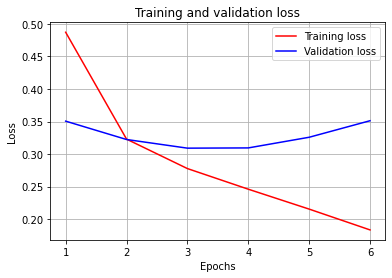

In [42]:
# 시각화할 항목 세팅 
history_dict = history.history
print(history_dict.keys())

# 시각화 시도
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# 빨간 실선으로 표시
plt.plot(epochs, loss, 'r', label='Training loss')
# 파란 실선으로 표시
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.show()

## 결론 및 회고 

- 다음의 세가지의 모델을 사용해보았고 그 중에서 제일 높은 정확도를 성취한 LSTM 으로 선택하여 모델구조를 찾았다. 
    1. ```1D CNN``` (시계열분석, text 분석을 하는데 사용되는 신경망)
    2. ```LSTM``` (기존의 RNN의 단점을 보완하여 장기, 단기 기억을 가능하게 설계된 신경망) 
    3. ```GlobalMaxPooling1D``` (여러개의 벡터 중 가장 큰 벡터를 반환하며 문맥을 보고 주요 특징을 뽑아낸다) 
    
    
- LSTM모델 앞에 CNN을 추가하면 성능이 더 나빠졌고 LSTM층을 하나 더 추가할 경우 결과는 크게 달라지지 않았지만 학습 곡선이 다르게 나타나는 것을 확인 할 수 있었다. 
- 간단하게 LSTM 레이어 하나만을 사용해서 하이퍼파라미터를 튜닝해보도록 하였다. 
- 정확도는 ```0.852``` -> ```0.857``` 으로 성능 향상

- 학습한 임베딩 결과 확인
    - '대박'이라는 단어를 통해서 유사단어를 찾아 보았다.
    - 대부분 영화리뷰로써 긍정적인 평가를 한 결과가 나왔다.

- 사전 학습된 워드임베딩적용 후 같은 파라미터로 학습 : 
    - 정확도 ```0.857``` -> ```0.860``` 로 성능 향상된 것을 확인했다.
    
    
- 학습한 임베딩 결과, 대박이라는 단어를 통하서 유사단어를 찾아보았고 긍정적인 결과를 얻었다. 네이버 영화리뷰 데이터 감성분석 정확도는 85% 이상을 달성하였지만 좀 더 90% 또는 그 이상이 되려면 어떻게 해야할지가 궁금해졌고 앞으로 node 과정을 더 진행하면서 알아갈 수 있길 기대한다. 